Using TensorFlow backend.


Starting with new model
Episode 10 of 1500
Episode 20 of 1500
Episode 30 of 1500
Episode 40 of 1500
Episode 50 of 1500
Episode 60 of 1500
Episode 70 of 1500
Episode 80 of 1500
Episode 90 of 1500
Episode 100 of 1500
Episode 110 of 1500
Episode 120 of 1500
Episode 130 of 1500
Episode 140 of 1500
Episode 150 of 1500
Episode 160 of 1500
Episode 170 of 1500
Episode 180 of 1500
Episode 190 of 1500
Episode 200 of 1500
Episode 210 of 1500
Episode 220 of 1500
Episode 230 of 1500
Episode 240 of 1500
Episode 250 of 1500
Episode 260 of 1500
Episode 270 of 1500
Episode 280 of 1500
Episode 290 of 1500
Episode 300 of 1500
Episode 310 of 1500
Episode 320 of 1500
Episode 330 of 1500
Episode 340 of 1500
Episode 350 of 1500
Episode 360 of 1500
Episode 370 of 1500
Episode 380 of 1500
Episode 390 of 1500
Episode 400 of 1500
Episode 410 of 1500
Episode 420 of 1500
Episode 430 of 1500
Episode 440 of 1500
Episode 450 of 1500
Episode 460 of 1500
Episode 470 of 1500
Episode 480 of 1500
Episode 490 of 1500
Episo

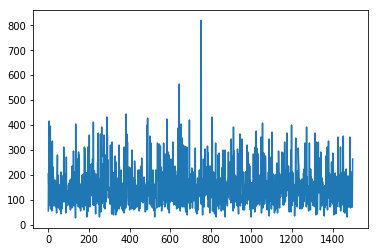

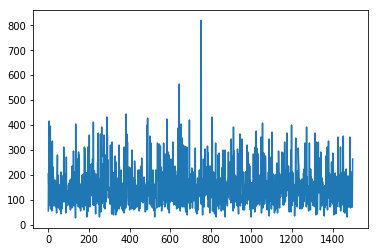

In [1]:
%matplotlib inline

import time
import puzzle
import csv
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import RMSprop
import numpy as np
import random

MAX_EPISODES=1500
INDEX_EPISODE=0
INDEX_EPOCH=1
INDEX_REWARD=2
INDEX_LOSS=3
INDEX_SCORE=4
INDEX_INCREMENT=5
INDEX_LOST=6
INDEX_LAST_STATE=7
INDEX_ACTION=8
INDEX_CURRENT_STATE=9
INDEX_WEIGHTS=10
INDEX_Q=7
INDEX_EXPLORATION=8
LOG_LOCATION='../logs/log.csv'
LOG_ITERATION=100 # Logs after this many global iterations
#ACCESS SCORE AS self.game.score
#ACCESS MATRIX AS self.game.matrix
#DECIDE ACTION TO TAKE IN act()
#POSSIBLE ACTIONS:
#	go up:		"'w'"
#	go left:	"'a'"
#	go right:	"'s'"
#	go down:	"'d'"

# To start from scratch, no inputs are needed when creating a new machine.
# If you want to continue from a previous model, initiate with parameter model='load'
# The machine will then start from the model file placed in : '../logs/my_model.h5'

class Machine():
    game=puzzle.GameGrid() # Game object
    epoch=0
    episode=0
    loss=0
    reward=0
    exploration=False
    verbose_logging=False
    weight_logging=False
    debug_logging=False
    action="'w'"
    model = Sequential()
    inputVector=np.zeros((1, 9))
    lastState=np.zeros((1, 9))
    Qvalues0=np.zeros((1,4))
    Qvalues1=np.zeros((1,4))
    acts = ["'w'","'s'","'d'","'a'"]
    act2index = {"'w'": 0, "'s'": 1, "'d'": 2, "'a'":3}
    gamma = 0.9    # Discount rate
    epsilon = 0.99  # Exploration rate
    iteration = 0
    log_iteration=0
    dump=False
    buffer=np.zeros((1,7))
    bufferShape=np.zeros((1,7))
    def __init__(self, verbose_logging_in=False,weight_logging_in=False,debug_logging_in=False,model='new'):
        # Short time memory
        self.memory = deque(maxlen=100000)
        self.gamma = 0.9    # discount rate
        self.e_decay = .99
        self.e_min = 0.05
        self.dump=False
        self.debug_logging=debug_logging_in
        self.verbose_logging=verbose_logging_in
        self.weight_logging=weight_logging_in
        # Create model
        self.createModel(model)
        # Initialise log
        with open('../logs/log.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if self.verbose_logging and self.weight_logging:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST","LAST STATE","ACTION","CURRENT STATE","WEIGHTS"]) 
                self.bufferShape=np.zeros((1,11))
            elif self.verbose_logging:
                writer.writerow(["EPISODE","EPOCH","LAST STATE","ACTION","CURRENT STATE","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST"])
                self.bufferShape=np.zeros((1,10))
            elif self.debug_logging:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST","Q","EXPLORATION"])
            else:
                writer.writerow(["EPISODE","EPOCH","REWARD","LOSS","TOTAL SCORE","INCREMENT IN SCORE","LOST"]) 
                self.bufferShape=np.zeros((1,7))
        self.buffer=self.bufferShape
        self.buffer=self.buffer.tolist()
    def createModel(self, model):
        if model == 'new':
            self.model.add(Dense(20, input_dim=9, activation='tanh')) # Adds the first layer with 16 inputs
            self.model.add(Dense(20, activation='tanh'))              # Adds Hidden layer with 20 nodes (Removed 'uniform')
            self.model.add(Dense(20, activation='tanh'))              # Adds Hidden layer with 20 nodes (Removed 'uniform')
            self.model.add(Dense(20, activation='tanh'))              # Adds Hidden layer with 20 nodes (Removed 'uniform')
            self.model.add(Dense(20, activation='tanh'))              # Adds Hidden layer with 20 nodes (Removed 'uniform')
            self.model.add(Dense(4, activation='linear'))             # Adds output layer with 20 nodes
            self.model.compile(loss='mse',optimizer=RMSprop(lr=0.01)) # Creates the model from all of the above
        if model == 'load':
            self.model = load_model('../logs/my_model.h5')
    def run(self):
        # Transform game state to 1D array
        for i in range(3):
            self.inputVector[0][0+3*i:3+3*i]=self.game.matrix[i]
        self.epoch=self.epoch+1 # Increase epoch
        self.iteration=self.iteration+1 # Increase global iteration
        self.log_iteration=self.log_iteration+1
        self.log() # Log model
        self.game.increment=self.get_reward() # Update reward if game has been lost
        self.game.key_down(self.act()) # Select action and update weights
        self.lastState=self.inputVector # For logging
        # Remember previous actions
        self.remember() 
        # Game loop
        self.game.update_idletasks
        self.game.update()
        # pool emaG
    def act(self):
        self.exploration=False
        if random.random() >= self.epsilon:  # Exploration
            self.exploration=True
            self.action = self.acts[random.randint(0,3)]
            return self.action
        else:
            # Predict Q values of current state
            self.Qvalues1=self.gamma*self.model.predict(self.inputVector)+self.game.increment
            # Extract Q value of the state
            Q1=np.amax(self.Qvalues1)
            #Construct target vector
            self.Qvalues1=self.Qvalues0
            self.Qvalues1[0][self.act2index[self.action]]=Q1 # Q0 with Q1 in the last step's action
            # Update weights with respect to last step's prediction of this step's Q values
            self.loss=self.model.train_on_batch(self.lastState, self.Qvalues1)
            # Select action with highest Q value
            self.Qvalues0=self.gamma*self.model.predict(self.inputVector)+self.game.increment
            self.action=self.acts[self.Qvalues0.argmax()] # Don't delete this variable, it's used when logging
            return self.action
    def remember(self):
        # memorize state; action; reward; next state ??inputVector == next state??
        self.memory.append((self.lastState, self.Qvalues1.argmax(), self.reward, self.inputVector, self.game.result))
    def replay(self, batch_size, state_size, action_size):
        # replay some of the actions at the end of training
        self.dump=False
        batch_size = min(batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)
        X = np.zeros((batch_size, state_size))
        Y = np.zeros((batch_size, action_size))
        for i in range(batch_size):
            state, action, reward, next_state, done = minibatch[i]
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)
        if self.epsilon > self.e_min:
            self.epsilon *= self.e_decay
    def log(self):
        # Log episode, epoch, reward, error, score, increment in score, lost, previous state, action, next state, weights 
        if self.weight_logging:
            for layer in self.model.layers:
                weights = layer.get_weights() # list of numpy arrays
        if self.weight_logging and self.verbose_logging:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.lastState,self.action,self.inputVector,weights])
        elif self.verbose_logging:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.lastState,self.action,self.inputVector])
        elif self.debug_logging:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result,self.Qvalues0[0],self.exploration])
        else:
            self.buffer.append([self.episode,self.epoch,self.reward,self.loss,self.game.score,self.game.increment,self.game.result])
        if (self.log_iteration == LOG_ITERATION) or self.dump:
            with open(LOG_LOCATION, 'a', newline='') as csvfile:
                self.buffer=self.buffer[1:] # Remove first line of zeros               
                writer = csv.writer(csvfile)
                for row in self.buffer:
                    writer.writerow(row)
                # Reset buffer
                self.buffer=self.bufferShape
                self.buffer=self.buffer.tolist()
                self.log_iteration=0
    def dump_logs(self):
        self.dump=True
        self.log()
    def plot(self):         
        with open(LOG_LOCATION,newline='') as csvfile:
            reader=csv.reader(csvfile)
            # Transform reader to array
            data=list(reader) 
            # Allocate arrays
            x=[]
            y=[]
            # Get rid of labels
            a=data.pop(0)
            for row in data:
                # Search for lost games
                if row[INDEX_LOST]=="True": # Needed because it's read as a string and not a bool
                    x.append(row[INDEX_EPISODE]) # Episode
                    y.append(row[INDEX_SCORE]) # Total score     
            # Plot results
            fig, ax = plt.subplots()
            ax.plot(x, y)
    def get_reward(self):
        l=0
        if self.game.result: # If the agent lost
            l = -2*self.game.increment-self.game.score
            # Reset game
            self.game.reset()
            self.epoch=0
            self.episode=self.episode+1
            if (self.episode % 10 == 0):
                print('Episode %d of %d' %(self.episode,MAX_EPISODES))
        self.reward=self.game.increment + l # Don't delete this variable, it's used for logging
        return (self.reward)
    def saveModel(self):
        self.model.save('../logs/my_model.h5')
    
print('Starting with new model')
our_machine = Machine(model='new',debug_logging_in=True)
while our_machine.episode<MAX_EPISODES:
    our_machine.run()
our_machine.dump_logs()
our_machine.plot()

# replay previous actions
print('Replaying')
our_machine.replay(32, 9, 4)

# Making logs
print('Making logs')
our_machine.dump_logs()
our_machine.plot()

# Save model
print('Saving model')
our_machine.saveModel()

In [ ]:
# Starting new training with same model
print('Starting new training with same model')

our_machine = Machine(model='load')
while our_machine.episode<MAX_EPISODES:
    our_machine.run()

# Making logs from double training
print('Making logs')
our_machine.dump_logs()
our_machine.plot()

# restart Kernel
# import IPython, time
# time.sleep(2)
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [ ]:
MAX_EPISODES=5

# Starting new training with same model
print('Starting new training with same model')

our_machine = Machine(model='load')
while our_machine.episode<MAX_EPISODES:
    our_machine.run()

# Making logs from double training
print('Making logs')
our_machine.dump_logs()
our_machine.plot()

In [ ]:
MAX_EPISODES=500

# Starting new training with same model
print('Starting new training with same model')

our_machine = Machine(model='load')
while our_machine.episode<MAX_EPISODES:
    our_machine.run()

# Making logs from double training
print('Making logs')
our_machine.dump_logs()
our_machine.plot()

# Save model
print('Saving model')
our_machine.saveModel()